### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import zipfile
import keras as ker
import json
import seaborn as sns
import glob

from sklearn.preprocessing import StandardScaler
from Functions.video_generation import VideoGeneration
from Functions.extracting_files import ExtractingFiles
from Functions.neural_networks import NeuralNetwork
from Functions.anoamly_detection import AnomalyDetection

In [2]:
zipped_file = os.getenv("ziped_file")
sesnor_data = os.getenv("folder_name")
output_dir = os.getenv('sensor_heatmaps')
video_output = os.getenv('temperature_output')

In [3]:
extract_files = ExtractingFiles()
extract_files.extract_zip(zipped_file, sesnor_data)

'Files extracted to Sensor_data'

In [4]:
initial_data = extract_files.read_all_excel_files(sesnor_data)

Reading file: Sensor_data\Data17052024-210552024\Sensor data[0474D,04750,04754,04756,04757,0475A,0475C,0475D,04762,04763,04765,04768,0476E,04771,04773,0477F,04787,04789,0478A,0478C](01_01_2024-20_05_2024) (1).xlsx
Reading file: Sensor_data\Data17052024-210552024\Sensor data[0478E,04791,04792,04796,0479B,0479D,0479E,047A8,047AA,047AD,047B2,047B6,047B7,047B8,047BA,047BB,047BC,047C1](01_01_2024-20_05_2024).xlsx
Reading file: Sensor_data\Data17052024-210552024\Sensor data[047C2,047C4,047C5,047C7,047C8,047C9,047CA,047CB,047CD,047CE,047D2,047D3,047D4,047D6,047D7,047DD,047F7,04802,04804,0480E](01_01_2024-20_05_2024).xlsx


In [5]:
initial_data['Day'] = pd.DatetimeIndex(initial_data['Time']).day
initial_data['Time_Instance'] = pd.DatetimeIndex(initial_data['Time']).time
initial_data['Year'] = pd.DatetimeIndex(initial_data['Time']).year
initial_data['Month'] = pd.DatetimeIndex(initial_data['Time']).month

In [6]:
initial_data.head()

,Time,Temperature,Humidity,Sensor Info,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month
0,2024-04-16 13:09:53,21.95,50.3,0474D T/RH IP67,0474D,0474D T/RH IP67,16,13:09:53,2024,4
1,2024-04-16 13:14:52,22.5,34.7,0474D T/RH IP67,0474D,0474D T/RH IP67,16,13:14:52,2024,4
2,2024-04-16 13:19:54,24.05,34.7,0474D T/RH IP67,0474D,0474D T/RH IP67,16,13:19:54,2024,4
3,2024-04-16 13:24:53,24.25,34.7,0474D T/RH IP67,0474D,0474D T/RH IP67,16,13:24:53,2024,4
4,2024-04-16 13:29:52,24.15,35.2,0474D T/RH IP67,0474D,0474D T/RH IP67,16,13:29:52,2024,4


In [7]:
with open('sensor_placement.json', 'r') as file:
    data = json.load(file)

keys_list = list(data.keys())

In [8]:
df_sorted = extract_files.sorting_data(initial_data, keys_list)
combined_data = df_sorted.copy()

In [9]:
combined_data = combined_data.drop_duplicates(subset=['Time', 'Sensor ID'])
combined_data = combined_data.drop('Sensor Info',axis=1)

In [10]:
combined_data.isnull().sum()

Time                0
Temperature      9351
Humidity         9351
Sensor ID           0
Sensor Name         0
Day                 0
Time_Instance       0
Year                0
Month               0
dtype: int64

In [11]:
sample_dataset = combined_data.copy()

In [12]:
sample_dataset = sample_dataset.groupby('Sensor ID').apply(lambda x: x.tail(30)).reset_index(drop=True)

C:\Users\malla\AppData\Local\Temp\ipykernel_19176\2761136616.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_dataset = sample_dataset.groupby('Sensor ID').apply(lambda x: x.tail(30)).reset_index(drop=True)


In [13]:
sample_dataset = extract_files.sorting_data(sample_dataset, keys_list)

In [14]:
video_gen = VideoGeneration()
frames = video_gen.frames_generation(sample_dataset, output_dir)

In [15]:
video_gen.video_generation(frames, video_output)

'Video saved as: sensor_heatmaps_temperature_video.avi'

In [16]:
combined_data['Humidity'] = combined_data['Humidity'].astype('float')
combined_data['Temperature'] = combined_data['Temperature'].astype('float')

In [17]:
list_sensors = ['04773','047B7','047B6','047AA','0478A']
timeseries_plot_data = combined_data[combined_data['Sensor ID'].isin(list_sensors)]

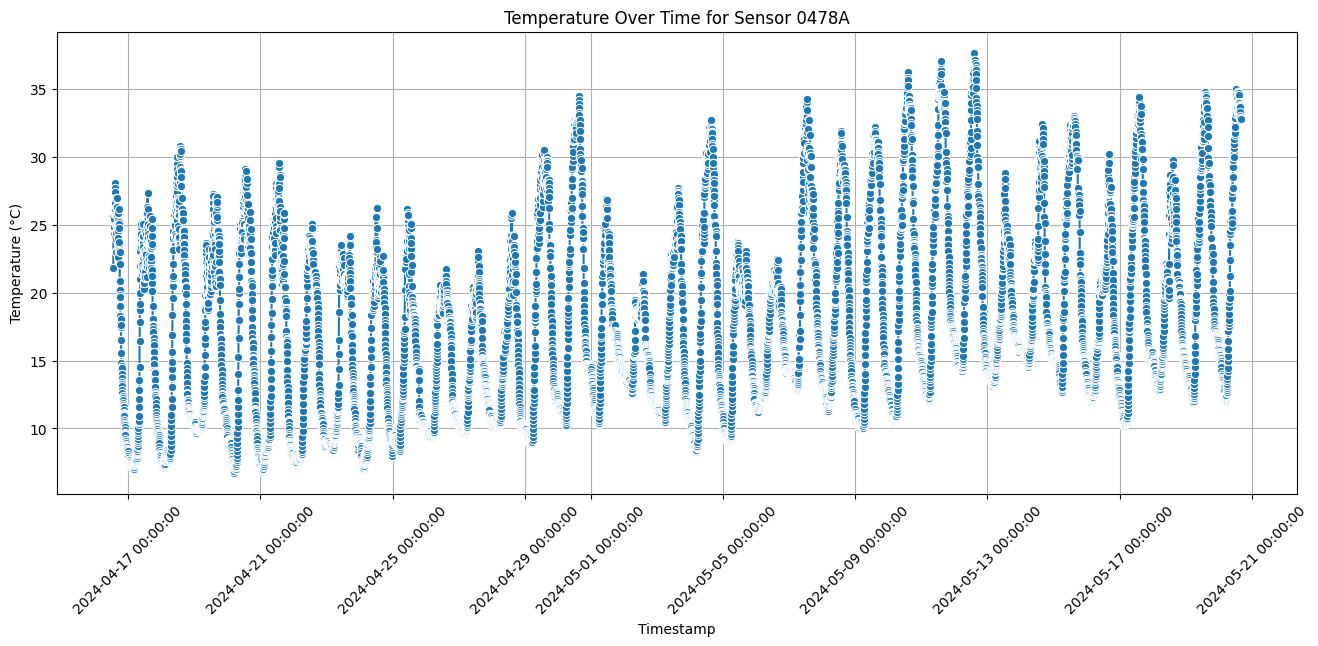

In [18]:
# Specify the sensor ID to plot
sensor_id = np.random.choice(timeseries_plot_data['Sensor ID'])

# Filter data for the specified sensor
sensor_data = timeseries_plot_data[timeseries_plot_data['Sensor ID'] == sensor_id]

# Create a figure for reuse
plt.figure(figsize=(16, 6))
sns.lineplot(x='Time', y='Temperature', data=sensor_data, marker='o')
plt.title(f'Temperature Over Time for Sensor {sensor_id}')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [19]:
combined_data['flag'] = combined_data.isna().any(axis=1).astype(int)

In [20]:
neural_network = NeuralNetwork()

In [21]:
if combined_data['Temperature'].isnull().sum() > 0 or combined_data['Humidity'].isnull().sum() > 0:
    if combined_data['Temperature'].isnull().sum() > 0:
        combined_data = neural_network.train_and_fill(combined_data, 'Temperature', 100)
    if combined_data['Humidity'].isnull().sum() > 0:
        combined_data = neural_network.train_and_fill(combined_data, 'Humidity', 100)
else:
    print('No null values detected!!!!!!')

Epoch 1/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 9.5151 - val_loss: 5.1244
Epoch 2/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5.2203 - val_loss: 5.1864
Epoch 3/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5.1819 - val_loss: 5.0651
Epoch 4/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.9825 - val_loss: 5.1743
Epoch 5/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.9575 - val_loss: 5.2323
Epoch 6/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.9505 - val_loss: 5.1099
Epoch 7/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.7680 - val_loss: 4.9760
Epoch 8/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.6763 - val_loss: 5.1608
Epoch 9/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.6932 - val_loss: 4.6949
Epoch 10/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.5013 - val_loss: 4.7249
Epoch 11/50
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.5095 - val_loss: 5.3317
Epoch 12/50
8008/8008 ━━━━━━━

In [22]:
final_dataset = combined_data.copy()

In [23]:
final_dataset[final_dataset['flag'] == 1]

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag
358,2024-05-05 05:01:20,9.55,83.82,047D6,047D6 T/RH IP67,5,05:01:20,2024,5,1
851,2024-05-20 08:31:34,14.37,83.69,047D6,047D6 T/RH IP67,20,08:31:34,2024,5,1
987,2024-05-07 09:29:43,21.66,59.14,047D6,047D6 T/RH IP67,7,09:29:43,2024,5,1
1001,2024-05-07 10:39:40,24.73,51.47,047D6,047D6 T/RH IP67,7,10:39:40,2024,5,1
1038,2024-05-20 15:01:20,30.64,44.55,047D6,047D6 T/RH IP67,20,15:01:20,2024,5,1
...,...,...,...,...,...,...,...,...,...,...
587639,2024-05-09 23:55:47,16.64,66.33,047CD,047CD T/RH IP67,9,23:55:47,2024,5,1
587941,2024-05-08 05:07:22,11.89,84.67,047CD,047CD T/RH IP67,8,05:07:22,2024,5,1
588035,2024-05-09 21:20:54,16.47,65.33,047CD,047CD T/RH IP67,9,21:20:54,2024,5,1
588047,2024-05-09 23:30:48,14.70,72.39,047CD,047CD T/RH IP67,9,23:30:48,2024,5,1


In [24]:
anomaly_detection = AnomalyDetection()
anomalies_list = []
temperature_color = 'green'
humidity_color = 'blue'

for sensor_id, sensor_data in combined_data.groupby('Sensor ID'):
    sensor_anomalies = anomaly_detection.detect_anomalies(sensor_data, sensor_id, temperature_color, humidity_color)
    anomalies_list.append(sensor_anomalies)

all_anomalies = pd.concat(anomalies_list)

In [25]:
non_anomalous_data = all_anomalies[(all_anomalies['Temperature_anomaly'] == 0) & (all_anomalies['Humidity_anomaly'] == 0)]

In [26]:
X_train = non_anomalous_data[['Temperature', 'Humidity']]
y_train_temp = non_anomalous_data['Temperature']
y_train_humidity = non_anomalous_data['Humidity']

In [27]:
non_anomalous_data.shape

(564404, 12)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [29]:
def model(input_shape):
    model = ker.models.Sequential([
        # ker.layers.Input(shape=input_shape),
        ker.layers.Dense(128, activation='relu',input_shape=(input_shape,)),
        ker.layers.Dense(128, activation='relu'),
        ker.layers.Dense(64, activation='relu'),
        ker.layers.Dense(64, activation='relu'),
        ker.layers.Dense(32, activation='relu'),
        ker.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [30]:
mlp_temp = model(X_train_scaled.shape[1])

e:\Final Desertation\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
mlp_temp.fit(X_train_scaled, y_train_temp, epochs=20, batch_size=64, validation_split=0.3)

Epoch 1/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 9.1674 - val_loss: 1.4425e-04
Epoch 2/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0028 - val_loss: 2.4627e-04
Epoch 3/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0030 - val_loss: 5.8314e-05
Epoch 4/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0039 - val_loss: 4.0048e-05
Epoch 5/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0026 - val_loss: 2.3758e-04
Epoch 6/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0016 - val_loss: 8.5068e-06
Epoch 7/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0015 - val_loss: 3.3934e-04
Epoch 8/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0019 - val_loss: 1.2439e-05
Epoch 10/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0013 - val_loss: 4.2164e-05
Epoch 11/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0018 - val_loss: 2

In [32]:
mlp_humidity = model(X_train_scaled.shape[1])

e:\Final Desertation\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
mlp_humidity.fit(X_train_scaled, y_train_humidity, epochs=20, batch_size=64, validation_split=0.3)

Epoch 1/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 159.4568 - val_loss: 0.0049
Epoch 2/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0364 - val_loss: 0.0018
Epoch 3/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0337 - val_loss: 0.1692
Epoch 4/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0303 - val_loss: 4.6500e-04
Epoch 5/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0222 - val_loss: 2.4235e-04
Epoch 6/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0180 - val_loss: 4.3548e-04
Epoch 7/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0186 - val_loss: 0.2986
Epoch 8/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0208 - val_loss: 0.0571
Epoch 9/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0165 - val_loss: 3.3798e-04
Epoch 10/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0225 - val_loss: 0.0683
Epoch 11/20
6174/6174 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0143 - val_loss: 2.2413e-04
Epo

In [34]:
anomalies = all_anomalies[(all_anomalies['Temperature_anomaly'] == 1) & (all_anomalies['Humidity_anomaly'] == 1)].copy()

X_anomalies = anomalies[['Temperature', 'Humidity']]
X_anomalies_scaled = scaler.transform(X_anomalies)

In [35]:
anomalies.loc[anomalies['Temperature_anomaly'] == 1, 'Temperature'] = 0
anomalies.loc[anomalies['Humidity_anomaly'] == 1, 'Humidity'] = 0

In [36]:
anomalies.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag,Temperature_anomaly,Humidity_anomaly
75823,2024-05-20 12:18:36,0.0,0.0,0474D,0474D T/RH IP67,20,12:18:36,2024,5,0,1,1
75873,2024-05-20 13:18:34,0.0,0.0,0474D,0474D T/RH IP67,20,13:18:34,2024,5,0,1,1
75877,2024-05-20 13:38:33,0.0,0.0,0474D,0474D T/RH IP67,20,13:38:33,2024,5,0,1,1
232588,2024-04-30 12:18:06,0.0,0.0,04750,04750 T/RH IP67,30,12:18:06,2024,4,0,1,1
232590,2024-04-30 12:28:04,0.0,0.0,04750,04750 T/RH IP67,30,12:28:04,2024,4,0,1,1


In [37]:
anomalies['Temperature'] = np.round(mlp_temp.predict(X_anomalies_scaled), 2)
anomalies['Humidity'] = np.round(mlp_humidity.predict(X_anomalies_scaled), 2)

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


In [38]:
all_anomalies.update(anomalies[['Temperature', 'Humidity']])

In [39]:
final_processed_data = all_anomalies.copy()

In [40]:
final_anomalies = final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)]

In [41]:
lastday = final_anomalies['Time'].max().date()
last_day_records = final_anomalies[final_anomalies['Time'].dt.date == lastday]

In [42]:
empty_data = final_processed_data[final_processed_data['flag'] == 1]
sensor_empty_data = empty_data[empty_data['Time'].dt.date == lastday]

In [43]:
sensor_sample_data = df_sorted[df_sorted['Time'].dt.date == lastday]

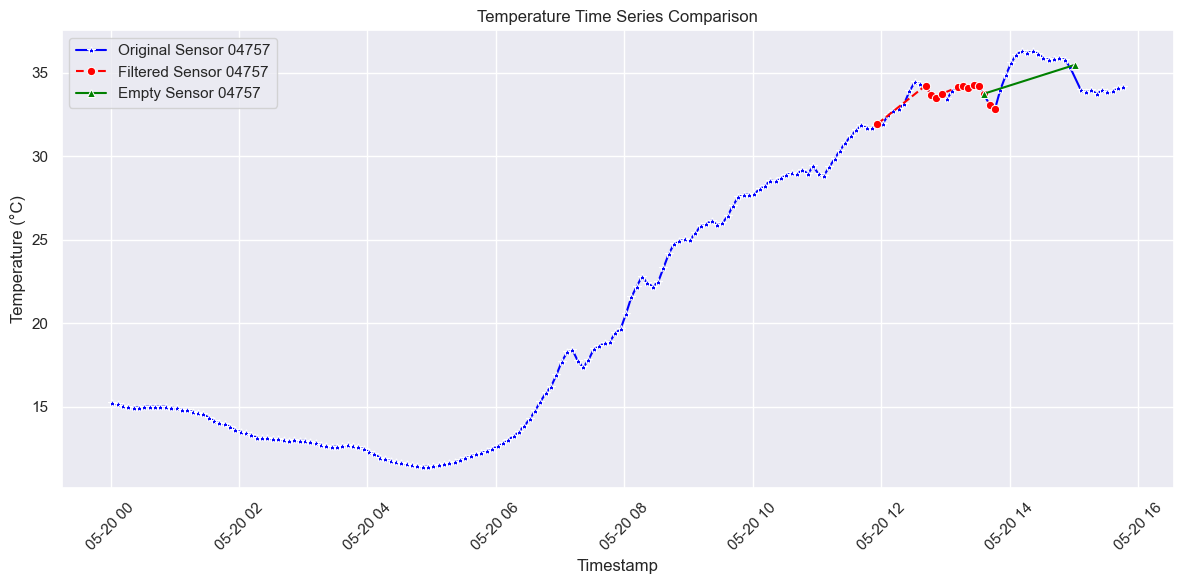

In [44]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Original data
sensor_data = sensor_sample_data[sensor_sample_data['Sensor ID'] == '04757']
sns.lineplot(x='Time', y='Temperature', data=sensor_data, 
             marker='*', color='blue',
             label='Original Sensor 04757')

# Filtered data
filtered_sensor_data = last_day_records[last_day_records['Sensor ID'] == '04757']
sns.lineplot(x='Time', y='Temperature', data=filtered_sensor_data, 
             marker='o', color='red',
             linestyle='--', label='Filtered Sensor 04757')

# Original data
filtered_empty_data = sensor_empty_data[sensor_empty_data['Sensor ID'] == '04757']
sns.lineplot(x='Time', y='Temperature', data=filtered_empty_data, 
             marker='^', color='green',
             label='Empty Sensor 04757')

plt.title('Temperature Time Series Comparison')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('Compare/original_and_filtered_plots.png')
plt.show()
